# Выбор локации для скважины

Необходимо принять решение о месте бурения новой скважины.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# импортируем библиотеки  

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#import scipy.stats as st
#from sklearn.metrics import confusion_matrix

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [2]:
# загрузим датасеты
try:
    data_0=pd.read_csv('/datasets/geo_data_0.csv')
    data_1=pd.read_csv('datasets/geo_data_1.csv')
    data_2=pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0=pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_0.csv')
    data_1=pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_1.csv')
    data_2=pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_2.csv')

In [3]:
all_data = [data_0,data_1,data_2]
for i in all_data:
    print('\n',i.head(),'\n')
    print(i.info(),'\n')
    print(i.describe(include='all'))
    print('_ _ _'*20)


       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

            id             f0             f1             f2        product
count   100000  100000.000000  100000.000000  100000.000000  100000.000000
unique   99990            NaN            NaN            NaN            NaN
top      bsk9y          

Видим наличие дубликотов в id скажин. Хотя в устовиях указанно, что данный показатель - уникальный. Посмотрим подробнее. 

In [4]:
data_0[data_0['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [5]:
data_1[data_1['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [6]:
data_2[data_2['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Строки не являются полными дубликатами. В реальной работе следовало бы запросить уточнение по возникшей ошибке. В данной работе будем считать, что это ошибка при именовании и мы имеем дело с разными скважинами. Т.к. в дальнейшем столбец с id использоваться не будет - не будем удалять строки.

In [7]:
for i in all_data:
    print(i.corr(), '\n')    

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000 

               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000 

               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000 



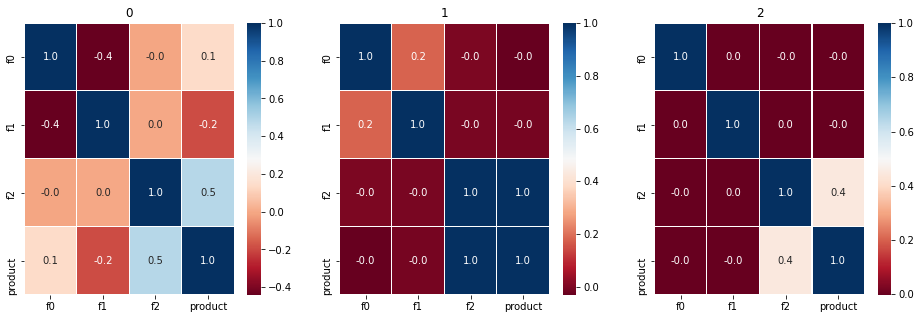

In [8]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for i,j in zip (all_data,range(3)):           
    sns.heatmap(i.corr(),annot=True, linewidths=.1, fmt= '.1f', ax=ax[j],  cmap="RdBu")             
    ax[j].set_title(str(j))
    #pd.plotting.scatter_matrix(i.drop('id', axis=1), figsize=(9, 9))

В регионе 1 высокая линейная зависимость между признаком в колонке 'f2' и целевым признаком.

In [9]:
#удалим столбцы неинформативные для обучения моделей (id)
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)
print(data_0.head(3),'\n',data_1.head(3),'\n',data_2.head(3),)

         f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.365080   73.037750
2  1.022732  0.151990  1.419926   85.265647 
           f0        f1        f2     product
0 -15.001348 -8.276000 -0.005876    3.179103
1  14.272088 -3.475083  0.999183   26.953261
2   6.263187 -5.948386  5.001160  134.766305 
          f0        f1        f2    product
0 -1.146987  0.963328 -0.828965  27.758673
1  0.262778  0.269839 -2.530187  56.069697
2  0.194587  0.289035 -5.586433  62.871910


In [10]:
#Проверим на наличие явных дубликатов
for i in all_data:
    print(i.duplicated().sum())

0
0
0


In [11]:
# рассмотрим коллиечество уникальных значений целевого признака
for i in all_data:
    a =  i['product'].unique()
    print(len(a))

100000
12
100000


Пропусков в данных не обнаружено Корреляции признаков всех трех месторождений различны В регионе 1 наиболее высокая линейная зависимость между признаком в колонке 'f2' и целевым признаком. Были выявлены не полные дубликаты (предположительно ошибка кодировки id скважин или повторные заборы для анализа) Было принято решение не удалять дубликаты. Размер трех выборок одинаковый Уникальных значений целевого признака в датасете 1 - всего 12, это может вызвать искажения при прогнозах. Все признаки являются численными


## Обучение и проверка модели

In [12]:
# извлекаем матрицу признаков
features_0 = data_0.drop(['product'], axis=1) 
features_1 = data_1.drop(['product'], axis=1) 
features_2 = data_2.drop(['product'], axis=1) 
# извлекаем целевой признак
target_0 = data_0['product']
target_1 = data_1['product']
target_2 = data_2['product']

Разделим данные на обучающую и валидационную выборки в соотношении 75:25.
 

In [13]:
# отделим 25% данных для обучающей и валидационной выборок
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=321)
print('Регион 0')
print('features_train_0','',features_train_0.shape[0])
print('features_valid_0','',features_valid_0.shape[0],'\n')

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=321)
print('Регион 1')
print('features_train_1','',features_train_1.shape[0])
print('features_valid_1','',features_valid_1.shape[0],'\n')

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=321)
print('Регион 2')
print('features_train_2','',features_train_2.shape[0])
print('features_valid_2','',features_valid_2.shape[0],'\n')

Регион 0
features_train_0  75000
features_valid_0  25000 

Регион 1
features_train_1  75000
features_valid_1  25000 

Регион 2
features_train_2  75000
features_valid_2  25000 



Нормализуем

In [14]:
scaler = StandardScaler()
scaler.fit(features_train_0)
features_train_0 = scaler.transform(features_train_0)
features_valid_0 = scaler.transform(features_valid_0)

scaler.fit(features_train_1)
features_train_1 = scaler.transform(features_train_1)
features_valid_1 = scaler.transform(features_valid_1)

scaler.fit(features_train_2)
features_train_2 = scaler.transform(features_train_2)
features_valid_2 = scaler.transform(features_valid_2)

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
Обучим модели и сделаем предсказания на валидационных выборках.

In [15]:
model_0 = LinearRegression(normalize=True).fit(features_train_0, target_train_0)
predictions_0 = model_0.predict(features_valid_0)

model_1 = LinearRegression(normalize=True).fit(features_train_1, target_train_1)
predictions_1 = model_1.predict(features_valid_1)

model_2 = LinearRegression(normalize=True).fit(features_train_2, target_train_2)
predictions_2 = model_2.predict(features_valid_2)

Сохраним предсказания,правильные ответы на валидационной выборке, объем топлива указанный в данных и предсказанный моделью.

In [16]:
rmse_0 = (mean_squared_error(target_valid_0, predictions_0)**0.5).round(2)
predictions_mean_0 = predictions_0.mean().round(2)
target_valid_sum_0 = target_valid_0.sum().round(2)
predictions_sum_0 = predictions_0.sum().round(2)

rmse_1 = (mean_squared_error(target_valid_1, predictions_1)**0.5).round(2)
predictions_mean_1 = predictions_1.mean().round(2)
target_valid_sum_1 = target_valid_1.sum().round(2)
predictions_sum_1 = predictions_1.sum().round(2)

rmse_2 = (mean_squared_error(target_valid_2, predictions_2)**0.5).round(2)
predictions_mean_2 = predictions_2.mean().round(2)
target_valid_sum_2 = target_valid_2.sum().round(2)
predictions_sum_2 = predictions_2.sum().round(2)

Оформим данные в таблицу

In [17]:
all_rmse =[rmse_0,rmse_1,rmse_2]
all_meen_predictions = [predictions_mean_0,predictions_mean_1,predictions_mean_2]
all_sum_target = [target_valid_sum_0,target_valid_sum_1,target_valid_sum_2]
all_sum_predictions = [predictions_sum_0,predictions_sum_1,predictions_sum_2]

df = {'rmse': all_rmse,
       'meen_predictions': all_meen_predictions,
     'sum_target':all_sum_target,
      'sum_predictions':all_sum_predictions
     }
df = pd.DataFrame(df, columns = ['meen_predictions','rmse', 'sum_target','sum_predictions'])
df

,meen_predictions,rmse,sum_target,sum_predictions
0,92.70,37.83,2315733.67,2317605.38
1,68.78,0.89,1719404.36,1719437.23
2,95.06,39.73,2365254.51,2376475.40


- meen_predictions -  средний запас предсказанного сырья в одной скважине
- rmse - отклонение
- sum_target - суммарный реальный запас 
- sum_predictions - суммарный предсказанный запас 

ВЫВОД



Было произведено обучение линейной регрессии на данных трех регионов. Лучшие показатели модели в регионе 1 (RMSE = 0.89) Модели в регионе 0 и 2 показали приблизительно одинаковые результаты (RMSE = 37.83 и 39.73) Показатели суммарного реального и прогнозируемого запаса очень близки. Средние запасы сырья в месторождениях по регионам (0,1,2) = 92.7 тыс, 68.78 тыс и 95.06 тыс баррелей соответственно. У модели 1 региона - хорошие результаты, однако у целевого признака было всего 12 значений из 100 000, что ставит под вопрос целесообразность ее использования.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных.


In [22]:
budget = 10000000000 #Бюджет на разработку скважин в регионе — 10 млрд рублей.
profit_per_barrel = 450 #При нынешних ценах один баррель сырья приносит 450 рублей дохода.
profit_barrel = 450000 #Доход с каждой единицы продукта составляет 450 тыс. рублей,т.к.объём указан в тыс баррелей.
total_counts = 500 # При разведке региона исследуют 500 точек 
counts = 200 # C помощью машинного обучения выбирают 200 лучших точек для разработки.
probability_of_losses = 0.025 # порог вероятности убытков 
bootstrap_samples = 1000 #количество выборок

Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. 

In [23]:
break_even_point = (budget/profit_barrel)/counts
print('Достаточный объем добычи для безубыточной разработки скважины:',break_even_point)

Достаточный объем добычи для безубыточной разработки скважины: 111.11111111111111


In [24]:
budget_per_point=(budget/counts)
print('Бюджет на разработку одной скважины:', budget_per_point/1000,'млн.руб')

Бюджет на разработку одной скважины: 50000.0 млн.руб


Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [25]:
print('Достаточный объем добычи для безубыточной разработки скважины:',round(break_even_point,2))
print('Средний запас сырья в скважине в 0 регионе:',predictions_mean_0)
print('Средний запас сырья в скважине в 1 регионе:',predictions_mean_1)
print('Средний запас сырья в скважине в 2 регионе:',predictions_mean_2)

Достаточный объем добычи для безубыточной разработки скважины: 111.11
Средний запас сырья в скважине в 0 регионе: 92.7
Средний запас сырья в скважине в 1 регионе: 68.78
Средний запас сырья в скважине в 2 регионе: 95.06


Минимальный объем сырья в каждой скважине должен составлять 111 тыс баррелей. Ни в одном из регионов средний запас в скважинах не преодолевает минимальный порог


## Расчёт прибыли и рисков 

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 Выберем скважины с максимальными значениями предсказаний.
 Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
 Рассчитаем прибыль для полученного объёма сырья.

In [28]:
def profit (predictions_x, target_x):
    top_prediction = pd.Series(predictions_x).reset_index(drop = True).sort_values(ascending=False)[:counts] 
    top_target = (target_x.reset_index(drop = True)[top_prediction.index])
    #print(len(top_target))
    #selected_max = top_prediction[:counts].sum()
    return round(((top_target.sum() * profit_barrel) - budget),2)
    #print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
   # print('Прибыль от залежей сырья составит: %.2f млн.рублей'%
   #       (((top_target.sum()*profit_barrel)-budget)/1000))

In [29]:
print("Прибыль от залежей сырья для скважин в 0 регионе:", profit(predictions_0,target_valid_0))
print("Прибыль от залежей сырья для скважин 1 регионе:",profit(predictions_1,target_valid_1))
print("Прибыль от залежей сырья для скважин в 2 регионе:", profit(predictions_2,target_valid_2))

Прибыль от залежей сырья для скважин в 0 регионе: 3201859753.4
Прибыль от залежей сырья для скважин 1 регионе: 2415086696.68
Прибыль от залежей сырья для скважин в 2 регионе: 2849964981.21


Все три региона потенциально прибыльные, для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка - расчитаем риски и прибыль для каждого региона.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [36]:
state = np.random.RandomState(123)
def risks_profits(predictions, target):
    predictions = pd.Series(predictions).reset_index(drop=True) 
    target = pd.Series(target).reset_index(drop=True)#inplace = True
    #print(target)
    #print(predictions)
    revenue = []
    for i in range(bootstrap_samples):
        target_sample = target.sample(n = total_counts, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]       
        revenue.append(profit(predictions_sample, target_sample))       
    revenue = pd.Series(revenue)
    lower = revenue.quantile(0.025)
    upper = revenue.quantile(0.975)
    mean_revenue = int(sum(revenue) / len(revenue))
    #risk = st.percentileofscore(revenue, 0)
    risk= (revenue < 0).mean()

    return ("Средняя выручка:{:.2f}".format(mean_revenue),
'95% доверительный интервал: {:.2f} - {:.2f}'.format(lower, upper),
'Риск убытков: {:.2%}'.format(risk))        

In [37]:
risks_profits(predictions_0,target_valid_0)

('Средняя выручка:389439292.00',
 '95% доверительный интервал: -90387923.76 - 864209205.95',
 'Риск убытков: 6.20%')

In [38]:
risks_profits(predictions_1,target_valid_1)

('Средняя выручка:446151227.00',
 '95% доверительный интервал: 53136667.59 - 851693890.47',
 'Риск убытков: 1.40%')

In [39]:
risks_profits(predictions_2,target_valid_2)

('Средняя выручка:336586803.00',
 '95% доверительный интервал: -202976037.50 - 852841326.63',
 'Риск убытков: 11.60%')

Согласно условиям задачи "После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%" Данному критерию соответствует регион 1, средняя прибыль в этом регионе составил 446.15 млн.рублей.Два других региона не подошли по указанному критерию.

ВЫВОД

Были рассмотрены данные геологоразведки трёх регионов. Все таблицы одного размера и содержат 5 столбцов по 100 000 строк. Пропусков в данных не обнаружено. Корреляции признаков всех трех месторождений различны. В регионе 1 была выявлена наиболее высокая линейная зависимость между признаком в колонке 'f2' и целевым признаком. Были выявлены не полные дубликаты (предположительно ошибка кодировки id скважин или повторные заборы для анализа) Было принято решение не удалять дубликаты. Уникальных значений целевого признака в регионе 1 - всего 12, это может вызвать искажения при прогнозах. Все признаки являются численными. 

Было определено, что минимальный объем сырья в каждой скважине должен составлять 111 тыс баррелей. При первичном исследовании ни в одном из регионов средний запас в скважинах не приближался к данному показателю. Было принято терешин рассматривать возможность разработки 200 наиболее перспективных скважин в каждом регионе.

Данные были разбиты на тестовую и валидационную выборки в соотношении 75:25 и нормализованы. Было произведено обучение модели линейной регрессии, а также применена техника Bootstrap с 1000 выборок. 
Вероятность убытков приемлемая для дальнейшей работы составила 2,5%. 

Таким образом наиболее перспективным для дальнейшей разработки является регион 1. Несмотря на небольшие запасы сырья 68.78 млн бар. относительно других регионов, риск убытков составляет 1,4% при потенциальной средней прибыли в 446 151 227.00 руб
